In [1]:
import numpy as np
# import urllib
import matplotlib.pyplot as plt
import scipy
from sklearn.decomposition import PCA
from math import log, exp
from random import shuffle
%matplotlib inline

In [2]:
# def parseData(fname):
#   for l in urllib.urlopen(fname):
#     yield eval(l)
def load_data(data_shuffle=False, regression=False, bias=True):
    print "Reading data..."
    dataFile = open("winequality-white.csv")
    header = dataFile.readline()
#     print header
    fields = ["constant"] + header.strip().replace('"','').split(';')
#     print fields
    featureNames = fields[:-1]
#     print featureNames
    labelName = fields[-1]
#     print labelName
    if bias:
        lines = [[1.0] + [float(x) for x in l.split(';')] for l in dataFile]
    else:
        lines = [[float(x) for x in l.split(';')] for l in dataFile]        
    if data_shuffle:
        shuffle(lines)
    X = [l[:-1] for l in lines]
    if regression:
        y = [l[-1] for l in lines]
    else:
        y = [l[-1] > 5 for l in lines]
    print "done"
    return X, y

In [3]:
def inner(x,y):
    return sum([x[i]*y[i] for i in range(len(x))])

def sigmoid(x):
    return 1.0 / (1 + exp(-x))


In [4]:
##################################################
# Logistic regression by gradient ascent         #
##################################################

# NEGATIVE Log-likelihood
def f(theta, X, y, lam):
    loglikelihood = 0
    for i in range(len(X)):
        logit = inner(X[i], theta)
        loglikelihood -= log(1 + exp(-logit))
        if not y[i]:
            loglikelihood -= logit
    for k in range(len(theta)):
        loglikelihood -= lam * theta[k]*theta[k]
    # for debugging
    # print "ll =", loglikelihood
    return -loglikelihood

# NEGATIVE Derivative of log-likelihood
def fprime(theta, X, y, lam):
    dl = [0]*len(theta)
    for i in range(len(X)):
        logit = inner(X[i], theta)
        for k in range(len(theta)):
            dl[k] += X[i][k] * (1 - sigmoid(logit))
            if not y[i]:
                dl[k] -= X[i][k]
    for k in range(len(theta)):
        dl[k] -= lam*2*theta[k]
    return np.array([-x for x in dl])

# Classifier evaluation

### 1. Randomly re-shuffle the data, and report the train/validation/test performance for $$\lambda \in \{0, 0.01, 1.0, 100.0\}$$

In [5]:
X, y = load_data(data_shuffle=True)
X_train = X[:int(len(X)/3)]
y_train = y[:int(len(y)/3)]
X_validate = X[int(len(X)/3):int(2*len(X)/3)]
y_validate = y[int(len(y)/3):int(2*len(y)/3)]
X_test = X[int(2*len(X)/3):]
y_test = y[int(2*len(X)/3):]

Reading data...
done


In [6]:
##################################################
# Train                                          #
##################################################

def train(lam):
    theta,_,_ = scipy.optimize.fmin_l_bfgs_b(f, [0]*len(X[0]), fprime, pgtol = 10, args = (X_train, y_train, lam))
    return theta

In [7]:
##################################################
# Predict                                        #
##################################################

def performance(theta):
    scores_train = [inner(theta,x) for x in X_train]
    scores_validate = [inner(theta,x) for x in X_validate]
    scores_test = [inner(theta,x) for x in X_test]

    predictions_train = [s > 0 for s in scores_train]
    predictions_validate = [s > 0 for s in scores_validate]
    predictions_test = [s > 0 for s in scores_test]

    correct_train = [(a==b) for (a,b) in zip(predictions_train,y_train)]
    correct_validate = [(a==b) for (a,b) in zip(predictions_validate,y_validate)]
    correct_test = [(a==b) for (a,b) in zip(predictions_test,y_test)]

    acc_train = sum(correct_train) * 1.0 / len(correct_train)
    acc_validate = sum(correct_validate) * 1.0 / len(correct_validate)
    acc_test = sum(correct_test) * 1.0 / len(correct_test)
    return acc_train, acc_validate, acc_test

In [8]:
##################################################
# Validation pipeline                            #
##################################################

for lam in [0, 0.01, 1.0, 100.0]:
    theta = train(lam)
    acc_train, acc_validate, acc_test = performance(theta)
    print("lambda = " + str(lam) + ";\ttrain=" + str(acc_train) + "; validate=" + str(acc_validate) + "; test=" + str(acc_test))

lambda = 0;	train=0.744485294118; validate=0.736680955297; test=0.754439681568
lambda = 0.01;	train=0.74387254902; validate=0.73790569504; test=0.754439681568
lambda = 1.0;	train=0.733455882353; validate=0.728107777097; test=0.736680955297
lambda = 100.0;	train=0.675857843137; validate=0.674219228414; test=0.676056338028


### 2. Report the number of true positives, true negatives, false positives, false negatives, and the Balanced Error Rate of the classifier

In [9]:
X, y = load_data()
X_train = X[:int(len(X)/3)]
y_train = y[:int(len(y)/3)]
X_validate = X[int(len(X)/3):int(2*len(X)/3)]
y_validate = y[int(len(y)/3):int(2*len(y)/3)]
X_test = X[int(2*len(X)/3):]
y_test = y[int(2*len(X)/3):]

Reading data...
done


In [10]:
lam = 0.01
theta = train(lam)

In [11]:
scores_test = [inner(theta, x) for x in X_test]
predictions_test = [s>0 for s in scores_test]
true_positives = sum([a and b for (a, b) in zip(predictions_test, y_test)])
false_positives = sum([a and not b for (a, b) in zip(predictions_test, y_test)])
true_negatives = sum([not a and not b for (a, b) in zip(predictions_test, y_test)])
false_negatives = sum([not a and b for (a, b) in zip(predictions_test, y_test)])
print "True Positives = ", true_positives, ", ",
print "True Negatives = ", true_negatives, ", ",
print "False Positives = ", false_positives, ", ",
print "False Negatives = ", false_negatives

tpr = true_positives * 1.0 / (true_positives + false_negatives)
tnr = true_negatives * 1.0 / (true_negatives + false_positives)
balanced_error_rate = 1.0 - (tpr + tnr) / 2.0
print "Balanced Error Rate = ", balanced_error_rate

True Positives =  1129 ,  True Negatives =  145 ,  False Positives =  321 ,  False Negatives =  38
Balanced Error Rate =  0.360701663412


### 3. By sorting the predictions by condence, compute the precision and the recall when returning the top 10, 500, and 1000 predictions

In [12]:
sorted_scores_test, sorted_y_test = (list(t) for t in zip(*sorted(zip(scores_test, y_test), reverse=True)))
topK = [10, 500, 1000]
for k in topK:
    total_relevant = sum(sorted_y_test) * 1.0
    total_returned = k * 1.0
    total_relevant_returned = sum(sorted_y_test[:k]) * 1.0
    precision = total_relevant_returned / total_returned
    recall = total_relevant_returned / total_relevant
    print "When returning top ", k, " predictions : Precision = ", precision, ", Recall = ", recall

When returning top  10  predictions : Precision =  1.0 , Recall =  0.00856898029135
When returning top  500  predictions : Precision =  0.956 , Recall =  0.409597257926
When returning top  1000  predictions : Precision =  0.864 , Recall =  0.740359897172


### 4. Precision vs Recall plot

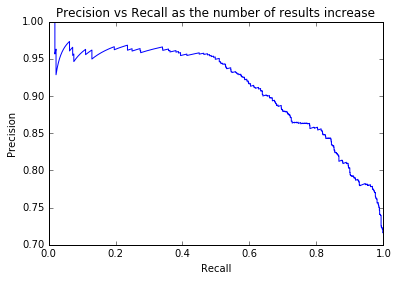

In [13]:
precision_list = []
recall_list = []
for k in range(1, len(y_test)):
    total_relevant = sum(sorted_y_test) * 1.0
    total_returned = k * 1.0
    total_relevant_returned = sum(sorted_y_test[:k]) * 1.0
    precision = total_relevant_returned / total_returned
    recall = total_relevant_returned / total_relevant
    precision_list.append(precision)
    recall_list.append(recall)
#     print "When returning Top ", k, " predictions : Precision = ", precision, ", Recall = ", recall
plt.plot(recall_list, precision_list)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs Recall as the number of results increase')
# print recall_list[-10:]

# Dimensionality Reduction

### 5. Reconstruction error when the data is compressed using the mean

In [14]:
err = np.array(X_train) - np.mean(X_train, axis=0)
# print err.shape
print "Reconstruction error when the data is compressed using the mean = ", np.sum(err ** 2)

Reconstruction error when the data is compressed using the mean =  3675818.61688


### 6. PCA components

In [15]:
pca = PCA()
pca.fit([arr[1:] for arr in X_train])
print "PCA components = \n", pca.components_

PCA components = 
[[ -3.23636346e-04   1.42201752e-04   3.17030713e-04   5.36390435e-02
    9.30284526e-05   2.54030965e-01   9.65655009e-01   3.19990241e-05
   -2.95831396e-04   3.84043646e-04  -1.00526693e-02]
 [ -7.57985623e-03  -1.66366340e-03   1.04742899e-03   5.21677266e-02
    4.49425600e-05   9.65020304e-01  -2.56793964e-01   7.90089050e-06
    5.24900596e-04  -1.09699394e-03  -2.89827657e-03]
 [  1.82124420e-02   2.54680710e-03   3.31838657e-03   9.93221259e-01
   -1.51888372e-04  -6.42297821e-02  -3.91682592e-02   4.30929482e-04
   -6.93199060e-03  -2.85216045e-03  -8.62920933e-02]
 [  1.56811999e-01   3.28220652e-03   1.66866136e-02   8.28549640e-02
   -6.91822288e-03   1.13029682e-03   5.39110108e-03  -9.49080503e-04
    2.68027305e-03   1.30498102e-03   9.83955205e-01]
 [  9.81360642e-01  -1.45890108e-02   5.92643662e-02  -3.17546064e-02
    5.07483182e-04   8.43759364e-03  -1.77578042e-03   6.03725221e-04
   -9.05011239e-02  -9.35630845e-03  -1.54417839e-01]
 [  7.765784

### 7. Reconstruction error using just four PCA dimensions

In [16]:
x_transformed = np.dot(pca.components_[4:], np.array([arr[1:] for arr in X_train]).T)
err = x_transformed.T - np.mean(x_transformed, axis=1)
print "Reconstruction error using 4 principal components = ", np.sum(err ** 2)

Reconstruction error using 4 principal components =  1345.4755741



### 8.Regression : Change in MSE (on the train and test sets) as the number of dimensions increase 

In [17]:
X, y = load_data(regression=True, bias=False)
X_train = X[:int(len(X)/3)]
y_train = y[:int(len(y)/3)]
X_validate = X[int(len(X)/3):int(2*len(X)/3)]
y_validate = y[int(len(y)/3):int(2*len(y)/3)]
X_test = X[int(2*len(X)/3):]
y_test = y[int(2*len(X)/3):]

Reading data...
done


In [18]:
train_mse_list = []
test_mse_list = []
for k in range(pca.components_.shape[0]):
    feat = np.dot(pca.components_[:k+1], np.array(X_train).T)
    feat = np.insert(feat, 0, 1, axis=0).T.tolist()
#     print feat[:5]
#     print y_train[:5]
    theta, residuals, rank, s = np.linalg.lstsq(feat, y_train)
    train_mse = residuals[0] / len(y_train)
#     print theta
#     print X_test
    feat_test = np.dot(pca.components_[:k+1], np.array(X_test).T)
    feat_test = np.insert(feat_test, 0, 1, axis=0)
#     print theta[:, None].shape, feat_test.shape, np.array(y_test)[:, None].shape
    test_error = np.dot(feat_test.T, theta[:, None]) - np.array(y_test)[:, None]
#     print test_error.shape
    test_mse = np.sum(test_error * test_error) / (len(y_test) * 1.0)
    train_mse_list.append(train_mse)
    test_mse_list.append(test_mse)

Train MSE for different number of dimensions used =  [0.86384243973592412, 0.84466943185576049, 0.82751611558520066, 0.69738327887529117, 0.68550155987923866, 0.66085398898732706, 0.65919451154521691, 0.6584860246102584, 0.63685661427823215, 0.6346878191481542, 0.61721175854356591]


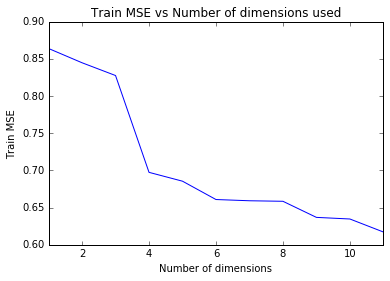

In [19]:
print "Train MSE for different number of dimensions used = ", train_mse_list
plt.plot(range(1, len(train_mse_list)+1), train_mse_list)
plt.title('Train MSE vs Number of dimensions used')
plt.xlabel('Number of dimensions')
plt.ylabel('Train MSE')
plt.xlim(1, len(train_mse_list))
plt.show()

Test MSE for different number of dimensions used =  [0.66348348996669582, 0.65558749316693776, 0.67835915193077889, 0.59909062198091823, 0.62319815648296362, 0.60387838007105243, 0.59727995924896626, 0.59450622441184542, 0.55550509614578014, 0.55620192020639936, 0.56887177280483969]


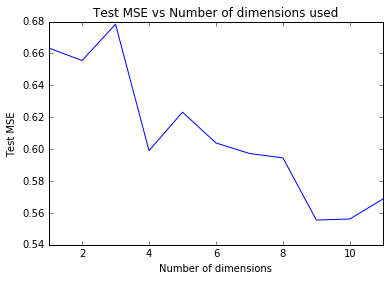

In [20]:
print "Test MSE for different number of dimensions used = ", test_mse_list
plt.plot(range(1, len(test_mse_list)+1),test_mse_list)
plt.title('Test MSE vs Number of dimensions used')
plt.xlabel('Number of dimensions')
plt.xlim(1, len(test_mse_list))
plt.ylabel('Test MSE')
plt.show()